<a href="https://colab.research.google.com/github/rrhkwk123/Work/blob/main/Biking_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Docs Used

[Prep Work](https://www.tensorflow.org/tutorials/keras/regression#the_auto_mpg_dataset)

[Normalization](https://www.tensorflow.org/tutorials/keras/regression#normalization)

[DNN Regression](https://www.tensorflow.org/tutorials/keras/regression#a_dnn_regression)

[Tune Parameters](https://www.tensorflow.org/tutorials/keras/keras_tuner)


# Import

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

from datetime import timedelta, date

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

bikes.keys()

Index(['Unnamed: 0', 'instant', 'dteday', 'season', 'hr', 'holiday',
       'workingday', 'weathersit', 'hum', 'windspeed', 'temp_c',
       'feels_like_c', 'casual', 'registered'],
      dtype='object')

# Prep

In [ ]:
bikes['total_riders'] = bikes['casual'] + bikes['registered']

bikes_data_to_analyze = bikes.drop(columns=['Unnamed: 0', 'instant', 'dteday', 'casual', 'registered'])

bikes_data_to_analyze.dropna()

bikes_data_to_analyze.head()

,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,total_riders
0,1,0,0,0,1,0.81,0,3.28,3.0014,16
1,1,1,0,0,1,0.80,0,2.34,1.9982,40
2,1,2,0,0,1,0.80,0,2.34,1.9982,32
3,1,3,0,0,1,0.75,0,3.28,3.0014,13
4,1,4,0,0,1,0.75,0,3.28,3.0014,1


# Train

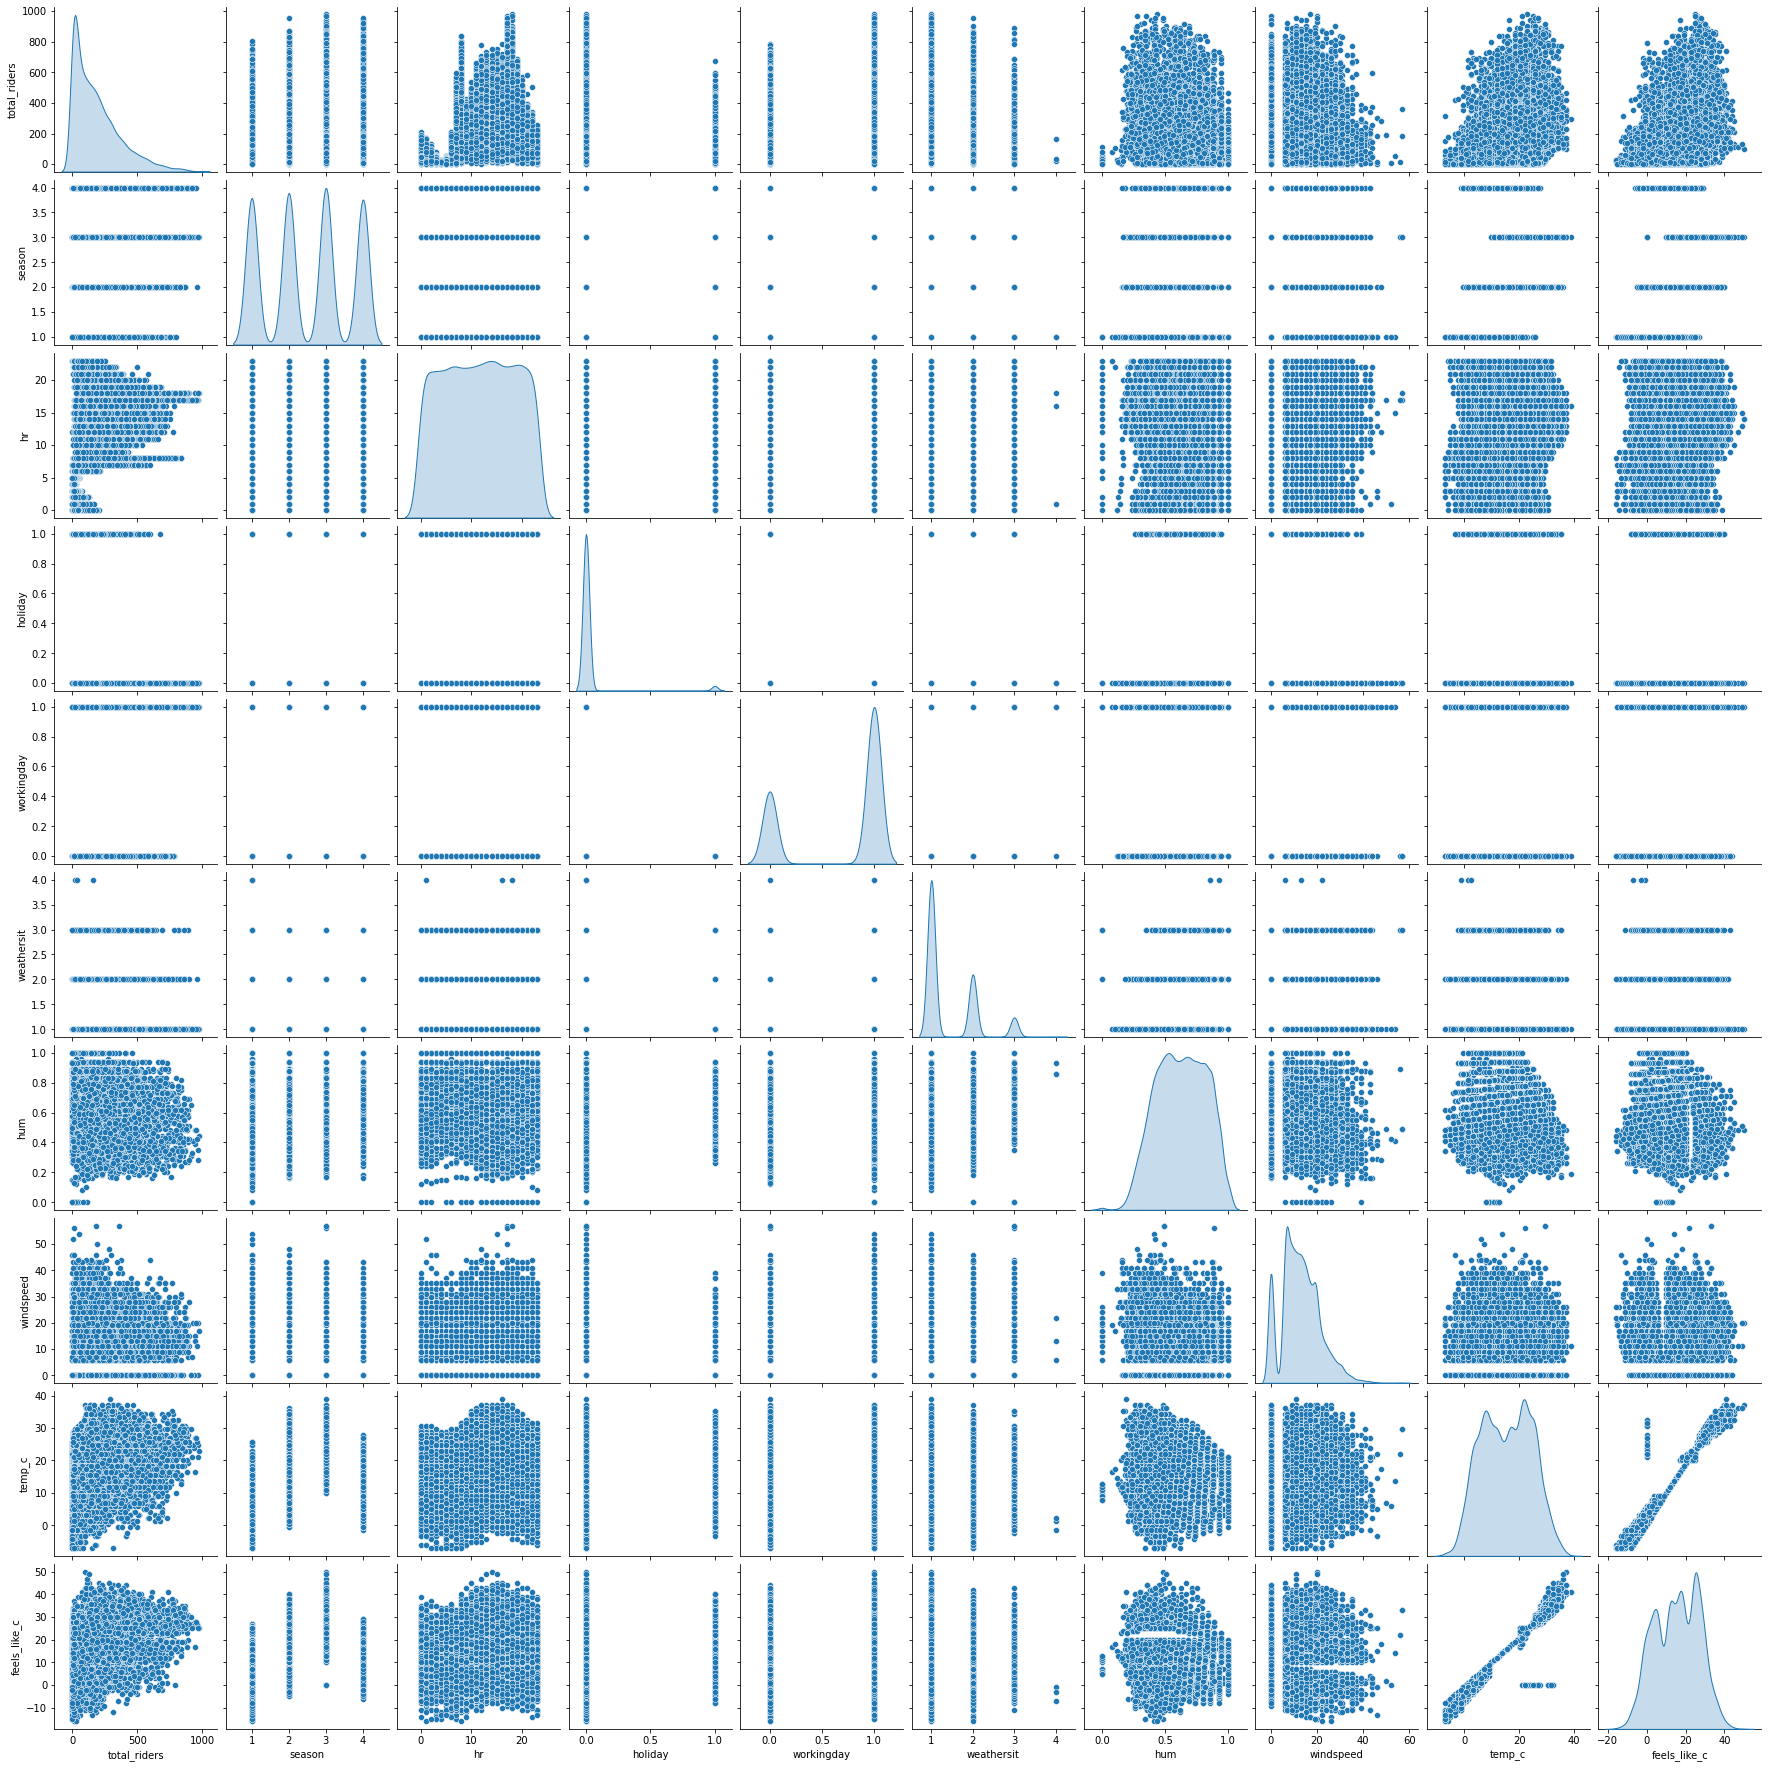

In [ ]:
# Set up the training data
train_dataset = bikes_data_to_analyze.sample(frac=0.75, random_state=42)

# Drop the training data before adding the remainder of the dataset as test data.
test_dataset = bikes_data_to_analyze.drop(train_dataset.index)

sns.pairplot(train_dataset[['total_riders', 'season', 'hr', 'holiday', 'workingday', 'weathersit', 'hum', 'windspeed', 'temp_c', 'feels_like_c']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
season,13034.0,2.500230,1.105517,1.00,2.0000,3.0000,3.0000,4.0
hr,13034.0,11.552938,6.895054,0.00,6.0000,12.0000,17.7500,23.0
holiday,13034.0,0.029155,0.168246,0.00,0.0000,0.0000,0.0000,1.0
workingday,13034.0,0.684364,0.464787,0.00,0.0000,1.0000,1.0000,1.0
weathersit,13034.0,1.425196,0.639115,1.00,1.0000,1.0000,2.0000,4.0
hum,13034.0,0.625775,0.193457,0.00,0.4700,0.6300,0.7800,1.0
windspeed,13034.0,12.750192,8.206247,0.00,7.0000,13.0000,17.0000,57.0
temp_c,13034.0,15.386412,9.063011,-7.06,7.9800,15.5000,23.0200,39.0
feels_like_c,13034.0,15.430834,11.351333,-16.00,5.9978,15.9968,24.9992,50.0
total_riders,13034.0,188.944530,180.264836,1.00,40.0000,142.0000,281.0000,977.0


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('total_riders')
test_labels = test_features.pop('total_riders')

# Normalization

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
season,2.500230,1.105517
hr,11.552938,6.895054
holiday,0.029155,0.168246
workingday,0.684364,0.464787
weathersit,1.425196,0.639115
hum,0.625775,0.193457
windspeed,12.750192,8.206247
temp_c,15.386412,9.063011
feels_like_c,15.430834,11.351333
total_riders,188.944530,180.264836


In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[ 2.50023    11.552938    0.02915452  0.68436396  1.4251957   0.6257749
 12.750192   15.386413   15.430834  ]


In [ ]:
# Check what the first row of data looks like before and after normalization
first_row = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('Before normalization:', first_row)
  print()
  print('After normalization:', normalizer(first_row).numpy())

Before normalization: [[ 3.   19.    0.    0.    1.    0.27 13.   29.6  30.  ]]

After normalization: [[ 0.45  1.08 -0.17 -1.47 -0.67 -1.84  0.03  1.57  1.28]]


# Overfit Correction

This section was an attempt to correct the overfitting of the data and an attempt at calculating an adaptive learning rate. I do not think it worked out too well since the learning rate appears flat but I tested it out to see what the loss is anyways. The learning rate here is very small.

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
N_VALIDATION = len(test_features)
N_TRAIN = len(train_features)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

get_optimizer()

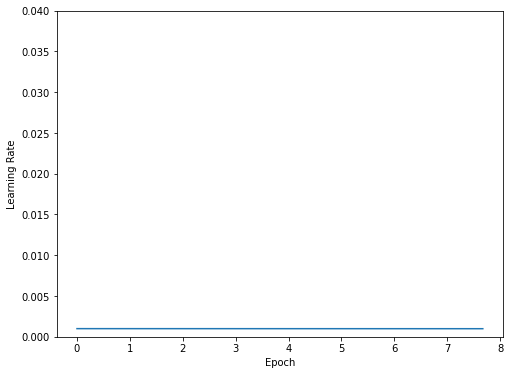

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,0.04])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=100):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss='mean_absolute_error')

  model.summary()

  history = model.fit(
    train_features, train_labels,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_split=0.2,
    verbose=1)
  return history

In [ ]:
model = tf.keras.Sequential([
  normalizer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(units=1)                                    
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 34,452
Trainable params: 34,433
Non-trainable params: 19
_________________________________________________________________


In [ ]:
compile_and_fit(model, 'test')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 34,452
Trainable params: 34,433
Non-trainable params: 19
_________________________________________________________________
Epoch 1/100
13034/13034 [==============================] - 16s 1ms/step - loss: 63.8613 - val_loss: 63.5002
Epoch 2

# Test

This is where the majority of the testing occurs. The structure of the model, the learning rate, the loss function and errors are all calculated here.

In [ ]:
# Define the structure of the model. These layers are what we play with.
# Decided on the following structure after playing around with a lot of different possibilities.
model = tf.keras.Sequential([
  normalizer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(units=1)                                    
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 34,452
Trainable params: 34,433
Non-trainable params: 19
_________________________________________________________________


In [ ]:
# Compile the model with the type of loss to analyze and with the learning rate we need. 
# We tested higher learning rates that this and got poorer results as well as lower learning rates
# and we got worse results as well. 
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.003),
    loss='mean_absolute_error')

In [ ]:

history = model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging for the sake of speed
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
326/326 [==============================] - 1s 2ms/step - loss: 54.7554 - val_loss: 55.8904
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 52.1514 - val_loss: 51.9506
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 50.9946 - val_loss: 53.1114
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 49.7890 - val_loss: 52.3014
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 48.8456 - val_loss: 51.8722
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 49.0561 - val_loss: 50.6028
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 48.0303 - val_loss: 50.1262
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 47.4867 - val_loss: 50.0050
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 47.4083 - val_loss: 52.6313
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - los

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,34.899097,47.266640,95
96,34.952057,48.950180,96
97,34.455593,48.177570,97
98,34.919750,48.708706,98
99,34.499352,48.506634,99


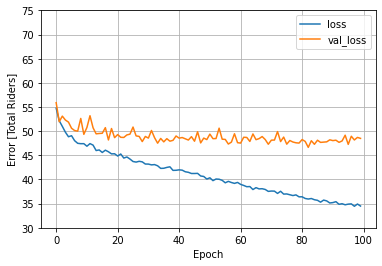

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([30, 75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Total Riders]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
predictions_array = model.predict(test_features)
predictions = pd.DataFrame(predictions_array, columns=['prediction'])
# predictions

merged_data = test_features.merge(test_labels, left_index=True, right_index=True)

final_results = merged_data.merge(predictions, left_index=True, right_index=True)

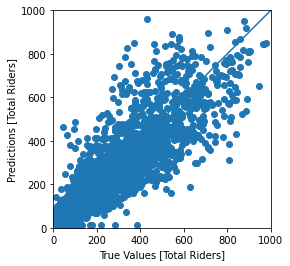

In [ ]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total Riders]')
plt.ylabel('Predictions [Total Riders]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

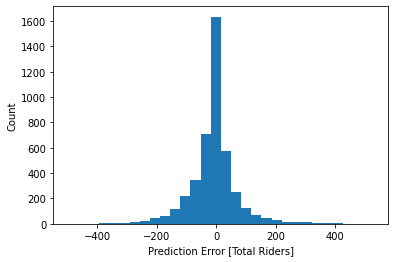

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=30)
plt.xlabel('Prediction Error [Total Riders]')
_ = plt.ylabel('Count')

In [ ]:
value = 0
error_list = error.value_counts().index.values
absolute_val_array = np.abs(np.array(error_list) - value)
print(absolute_val_array)

[ 8.29244995  9.29244995 11.29244995 ... 80.66503906 23.16616821
  8.62504196]


In [ ]:
smallest_difference_index = absolute_val_array.argmin()
closest_element = np.array(list)[smallest_difference_index]

print(closest_element)

0.009975433349609375


In [ ]:
indecies_to_use = range(-100, 100)

total_count = 0
total_count_within_10 = 0

for x in error.round().value_counts(sort=True):
  total_count += x

for x in indecies_to_use:
  total_count_within_10 += error.round().value_counts(sort=True).loc[x]

print(total_count_within_10 / total_count)

0.8467203682393556
